# NLP with Keras

This projects utilzies Keras to make predictions on movie genre based on the movie's plot.

This notebook focuses on the training of the model. Predictions done in Predicting_Holdout_set notebook.

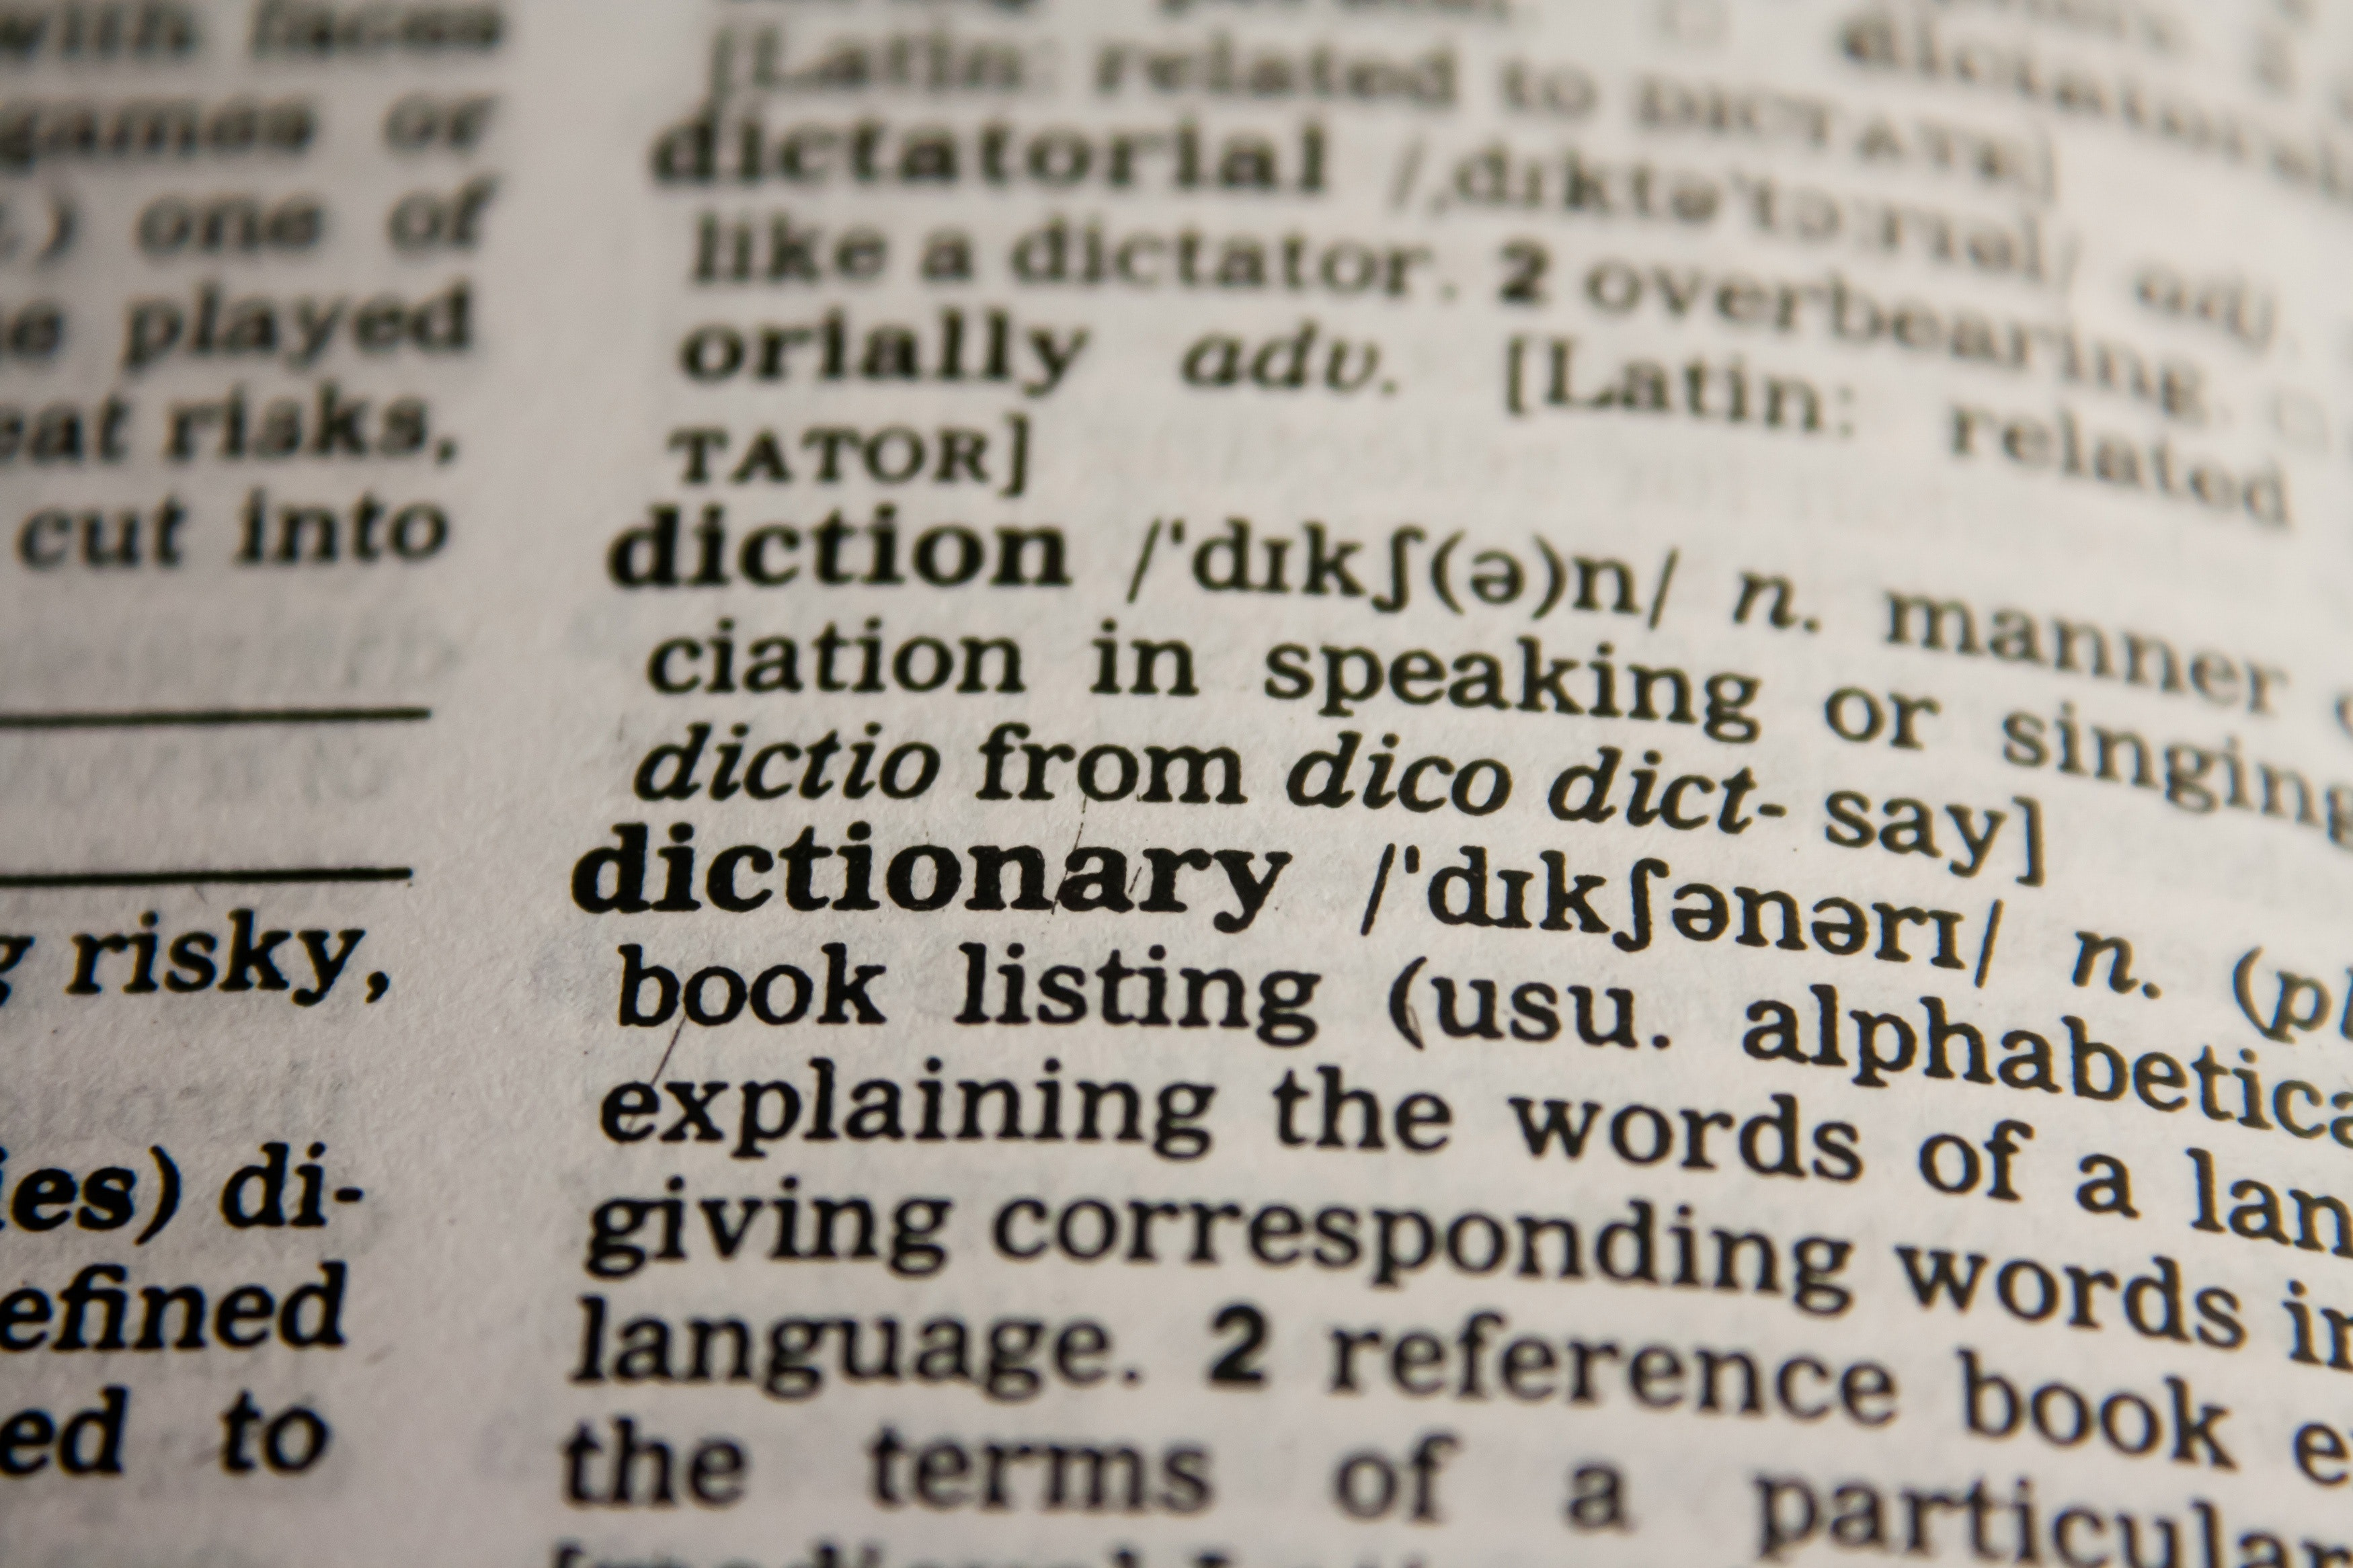

##### Photo by [Pixabay](https://www.pexels.com/@pixabay) from [Pexels](https://www.pexels.com)

Repository structure:
- All csv's can be found in the /data folder
- All images can be found in the /images folder

Note:
- Pickled data not available in repository due to exceeding github file size limit

## Library Import

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers, metrics 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight

import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

#Ensure gpu connection for spacy and tensorflow
assert torch.cuda.is_available() == True
assert len(tf.config.list_physical_devices('GPU')) == 1

## Data and Baseline Model

Here, I read in the training data as well as remove missing values. They are simply dropped as the 'Cast' column will not be used.

After this, the data is split into a test/train split

In [2]:
#Read in data
df = pd.read_csv('data/movie_train.csv', index_col=0)

df.isna().sum()
df.drop(columns = 'Cast', inplace = True)
df.reset_index(drop = True, inplace = True)
df.shape, df.isna().sum()

((10682, 5),
 Release Year    0
 Title           0
 Plot            0
 Director        0
 Genre           0
 dtype: int64)

In [ ]:
#Dependent/independent split
X = df['Plot']
y = df['Genre']

In [ ]:
#Train/Test split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

## Tokenize and Vectorize

I utilize the spacy library to tokenize the documents before utilizing TFidfVectorizer to vectorize the tokens.

The tokenizer function works in the following order:
1. Remove punctuations and numbers
    - Plot webscraped from Wikipedia, in-text citations in plot
2. Turn document into spacy doc
3. Remove character names and pronouns
4. Lemmatize, lowercase, remove spaces in words
5. Remove stop words from document

In [4]:
#Gather stop words, punctuation, numbers for removal
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuation = [*string.punctuation , *[str(x) for x in list(range(0,10))]]

#Ensure spacy utilizes gpu over cpu
spacy.prefer_gpu()
#Load spacy
nlp = spacy.load('en_core_web_trf')

#Define spacy tokenizer
def spacy_tok(text):
    '''
    Remove punctuation, character names, and pronouns before
    lemmatize words and remove stop words
    '''
    doc = ''.join([x for x in text if x not in punctuation])
    toks = nlp(doc)
    toks = [word for word in toks if word.pos_ != 'PROPN' and word.pos_ != 'PRON']
    toks = [word.lemma_.lower().strip() for word in toks]
    toks = [word for word in toks if word not in stop_words]
    return toks

In [34]:
#Instantiate vectorizer
tfidf = TfidfVectorizer(tokenizer = spacy_tok,
                        sublinear_tf = True,
                        max_df = .8,
                        min_df = 10,
                        ngram_range = (1, 3))

Here I tokenize/vectorize the data.

I also encode the target variables. This is not necessary for some models, but due to the Keras parameters, the target will need to be encoded.

In [35]:
#Tokenize/Vectorize data
X_train_feat = tfidf.fit_transform(X_train).toarray()
X_test_feat = tfidf.transform(X_test).toarray()

#Encode target variable
encoder = LabelEncoder()

encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.transform(y_test)

The following cells are to export/import the data.

Running the TfidfVectorizer with a spacy tokenizer takes approximately 15 minutes to transform the test/train data so the data was pickled.

In [47]:
#-- Tokenizer ~15min runtime. Results saved --#

#pickle_out = open(".pickle/X_train_feat.pickle","wb")
#pickle.dump(X_train_feat, pickle_out)
#pickle_out.close()

#pickle_out = open(".pickle/X_test_feat.pickle","wb")
#pickle.dump(X_test_feat, pickle_out)
#pickle_out.close()

In [5]:
#-- Reading results back in on restart --#

#infile = open(".pickle/X_train_feat.pickle",'rb')
#X_train_feat = pickle.load(infile)
#infile.close()

#infile = open(".pickle/X_test_feat.pickle",'rb')
#X_test_feat = pickle.load(infile)
#infile.close()

Here I run a baseline model to have a metric to measure against.

I use a Multinomial Naive Bayes for this purpose.

In [106]:
#Instantiate baseline Naive Bayes model
mnb = MultinomialNB()

mnb.fit(X_train_feat, y_train)
y_hat = mnb.predict(X_test_feat)

#Score baseline model
f1_score(y_train, mnb.predict(X_train_feat), average = 'weighted'), f1_score(y_test, y_hat, average = 'weighted')

(0.4628830381413872, 0.36520626490896835)

## Keras Modeling

First, I create a dictionary of class weights. There is a major class imbalance between movies so this allows the model to address this, placing more weight on movie genres that have a lower count.

In [107]:
#Gather class weights to address class imbalance in Keras model
class_weights = dict(zip(np.unique(encoded_y_train),
                         class_weight.compute_class_weight('balanced',
                                                           np.unique(encoded_y_train),
                                                           encoded_y_train)
                        )
                    ) 

The following cells are minor tensorflow configurations that do the following:
- Cap gpu usage if necessary, currently unused but set to 80% usage cap
- Configuration to give tensorflow full memory access

In [108]:
#Configure tensorflow gpu usage
config = ConfigProto()

#gpu usage cap
#config.gpu_options.per_process_gpu_memory_fraction = .8

#Allow tensorflow to vary gpu usage
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Keras Model

The following configuration was selected to account for:
- Addressing class imbalance between movie genres
    - For example: Crime movies accounted for only 3% of the data
- Accounting for overfitting
    - Validation accuracy would fall as training set accuracy rose
    - Training set metrics lowered in exchange for higher validation score

In [ ]:
num = 100
batch_size = 500
#Configure optimzer learning rate
opt = tf.keras.optimizers.Adamax(learning_rate=0.00075)

#Instantiate Keras model
model = Sequential()
model.add(Dense(num*2, activation = 'relu', input_dim = X_train_feat.shape[1]))
model.add(Dropout(0.6))
model.add(Dense(num/2, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation = 'softmax'))

#Compile/fit model
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics = [metrics.sparse_categorical_accuracy])

results = model.fit(X_train_feat, encoded_y_train,
                    epochs = 170,
                    batch_size = batch_size,
                    validation_split = .25,
                    shuffle = True,
                    class_weight = class_weights
                   )

I graphed the loss as well as the sparse categorical accuracy for the training and validation sets.

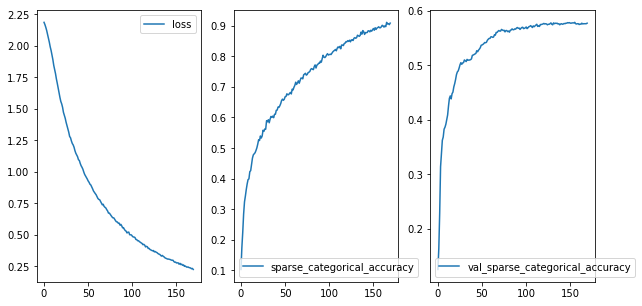

In [110]:
#Gather results
loss_graph = results.history['loss']
accuracy_graph = results.history['sparse_categorical_accuracy']
val_accuracy_graph = results.history['val_sparse_categorical_accuracy']

#Plot loss and accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
sns.lineplot(x=results.epoch, y=loss_graph, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=accuracy_graph, ax=ax2, label='sparse_categorical_accuracy')
sns.lineplot(x=results.epoch, y=val_accuracy_graph, ax=ax3, label='val_sparse_categorical_accuracy');

In [111]:
#Predict on test split
test = model.predict(X_test_feat)

#Retrieve f1-score
f1_score(encoded_y_test, test.argmax(axis=1), average = 'weighted')

0.6030469925890902

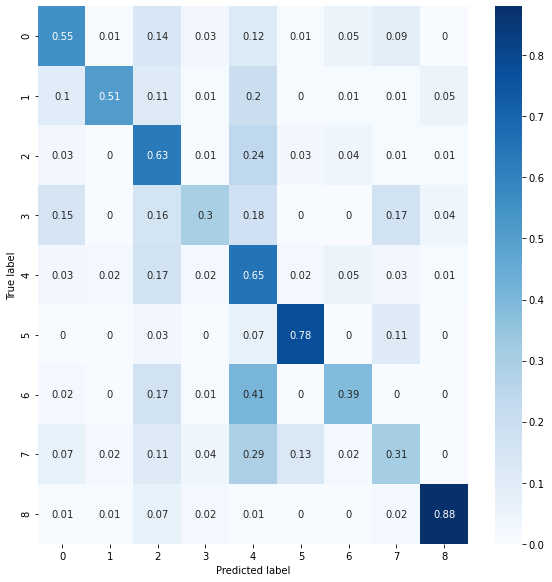

In [112]:
#Create confusion matrix for results
con_mat = tf.math.confusion_matrix(encoded_y_test,
                                   test.argmax(axis=1)).numpy()

#Normalize dataa
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

#plot
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()